# EPFL - Machine Learning Project 2

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
import joblib
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.tree import export_graphviz
from IPython import display

In [2]:
%matplotlib inline

# Define measurement

In [3]:
def rmse(y_true, y_pred):
# Calculate the root mean square error for two arrays
# Input: true value, predicted value
# Output: Root mean square error
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    return rmse

In [4]:
def lcc(y_true, y_pred):
# Calculate the Pearson correlation coefficient for two arrays
# Input: true value, predicted value
# Output: Pearson correlation coefficient
    lcc, _ = stats.pearsonr(y_true, y_pred)
    return lcc

In [5]:
def srocc(y_true, y_pred):
# Calculate the Spearman rank correlation coefficient for two arrays
# Input: true value, predicted value
# Output: Spearman rank correlation coefficient
    srocc, _ = stats.spearmanr(y_true, y_pred)
    return srocc

In [6]:
def accuracy(y_true, y_pred):
# Calculate the mean relative accuracy for two arrays
# Input: true value, predicted value
# Output: mean relative accuracy
    ratio = abs(y_true - y_pred) / y_true
    return 1 - np.mean(ratio)

In [7]:
scorer = {}
scorer['rmse'] = metrics.make_scorer(rmse, greater_is_better=False)
scorer['lcc'] = metrics.make_scorer(lcc, greater_is_better=True)
scorer['srocc'] = metrics.make_scorer(srocc, greater_is_better=True)
scorer

{'rmse': make_scorer(rmse, greater_is_better=False),
 'lcc': make_scorer(lcc),
 'srocc': make_scorer(srocc)}

In [8]:
measurement = ['mean_train_rmse', 'mean_test_rmse', 'mean_train_lcc', 'mean_test_lcc', 
               'mean_train_srocc', 'mean_test_srocc']

# Read data

In [9]:
features = pd.read_pickle('features.pkl')
labels = pd.read_pickle('labels.pkl')

# Group CV generator

In [10]:
# group our dataset and each group has three samples
group_label = np.arange(len(features.index) / 3) 
group_label = np.matlib.repmat(group_label,3,1)
group_label = group_label.reshape(-1,1, order='F')

In [11]:
# CV generator: generate train and test index w.r.t group label
# and using shuffle technique
def CV_Generator(features, labels, group_label, n=8, test_ratio=0.2):
    CV_Group = GroupShuffleSplit(n_splits=n, test_size=test_ratio, random_state=8)
    for train, test in CV_Group.split(features, labels, groups=group_label):
        yield train, test

# Random Forest

## Parameters grid search - first round

In [12]:
parameters_grid_1st = {}

In [13]:
# initial the hyper-parameters grid used for grid search
# At first, grid search the hyper-parameter with small ranges
# for example, max_features, bootstrap
parameters_grid_1st['n_estimators'] = [100]
parameters_grid_1st['criterion'] = ['mse', 'mae']
parameters_grid_1st['max_depth'] = [int(x) for x in range(7, 10)]
parameters_grid_1st['min_samples_split'] = [2,3,4,5]
parameters_grid_1st['min_samples_leaf'] = [2,3,4,5]
parameters_grid_1st['max_features'] = ['auto', 'log', 'sqrt']
parameters_grid_1st['bootstrap'] = [True, False]
parameters_grid_1st['verbose'] = [0]

In [14]:
parameters_grid_1st

{'n_estimators': [100],
 'criterion': ['mse', 'mae'],
 'max_depth': [7, 8, 9],
 'min_samples_split': [2, 3, 4, 5],
 'min_samples_leaf': [2, 3, 4, 5],
 'max_features': ['auto', 'log', 'sqrt'],
 'bootstrap': [True, False],
 'verbose': [0]}

In [15]:
# initial raw model with default hyper-parameters
Reg_video = RandomForestRegressor(random_state=8, n_jobs=-1)

In [16]:
parameters_grid_search_1st = GridSearchCV(estimator = Reg_video, param_grid = parameters_grid_1st, 
                          cv = CV_Generator(features, labels, group_label), n_jobs = -1, verbose = 1, return_train_score=True, 
                                      error_score = np.nan, scoring = scorer, refit = 'rmse', iid=False)

In [17]:
parameters_grid_search_1st.fit(features, labels)

Fitting 8 folds for each of 576 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed:  4.7min finished


GridSearchCV(cv=<generator object CV_Generator at 0x117cfceb8>,
       error_score=nan,
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [100], 'criterion': ['mse', 'mae'], 'max_depth': [7, 8, 9], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5], 'max_features': ['auto', 'log', 'sqrt'], 'bootstrap': [True, False], 'verbose': [0]},
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score=True,
       scoring={'rmse': make_scorer(rmse, greater_is_better=False), 'lcc': make_scorer(lcc), 'srocc': make_scorer(srocc)},
       verbose=1)

In [18]:
parameters_grid_search_1st.best_params_ # best parameters found

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100,
 'verbose': 0}

## Parameters grid search - second round

In [19]:
parameters_grid_2nd = {}

In [20]:
# initial the hyper-parameters grid used for second grid search
# based on the result from the best params of first grid search
# further optimize the hyper-params with small ranges
parameters_grid_2nd['n_estimators'] = [100]
parameters_grid_2nd['criterion'] = ['mse']
parameters_grid_2nd['max_depth'] = [8]
parameters_grid_2nd['min_samples_split'] = [int(x) for x in range(5, 20)]
parameters_grid_2nd['min_samples_leaf'] = [3]
parameters_grid_2nd['max_features'] = ['auto']
parameters_grid_2nd['bootstrap'] = [True]
parameters_grid_2nd['verbose'] = [0]
parameters_grid_2nd['oob_score'] = [True, False]

In [21]:
parameters_grid_2nd

{'n_estimators': [100],
 'criterion': ['mse'],
 'max_depth': [8],
 'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'min_samples_leaf': [3],
 'max_features': ['auto'],
 'bootstrap': [True],
 'verbose': [0],
 'oob_score': [True, False]}

In [22]:
parameters_grid_search_2nd = GridSearchCV(estimator = Reg_video, param_grid = parameters_grid_2nd, 
                          cv = CV_Generator(features, labels, group_label), n_jobs = -1, verbose = 1, return_train_score=True, 
                                      error_score = np.nan, scoring = scorer, refit = 'rmse', iid=False)

In [23]:
parameters_grid_search_2nd.fit(features, labels)

Fitting 8 folds for each of 30 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.4s finished


GridSearchCV(cv=<generator object CV_Generator at 0x117cfcd58>,
       error_score=nan,
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [100], 'criterion': ['mse'], 'max_depth': [8], 'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'min_samples_leaf': [3], 'max_features': ['auto'], 'bootstrap': [True], 'verbose': [0], 'oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score=True,
       scoring={'rmse': make_scorer(rmse, greater_is_better=False), 'lcc': make_scorer(lcc), 'srocc': make_scorer(s

In [24]:
parameters_grid_search_2nd.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100,
 'oob_score': True,
 'verbose': 0}

### Training curve

In [25]:
param_name = 'param_min_samples_split'
param_value = parameters_grid_search_2nd.cv_results_[param_name]

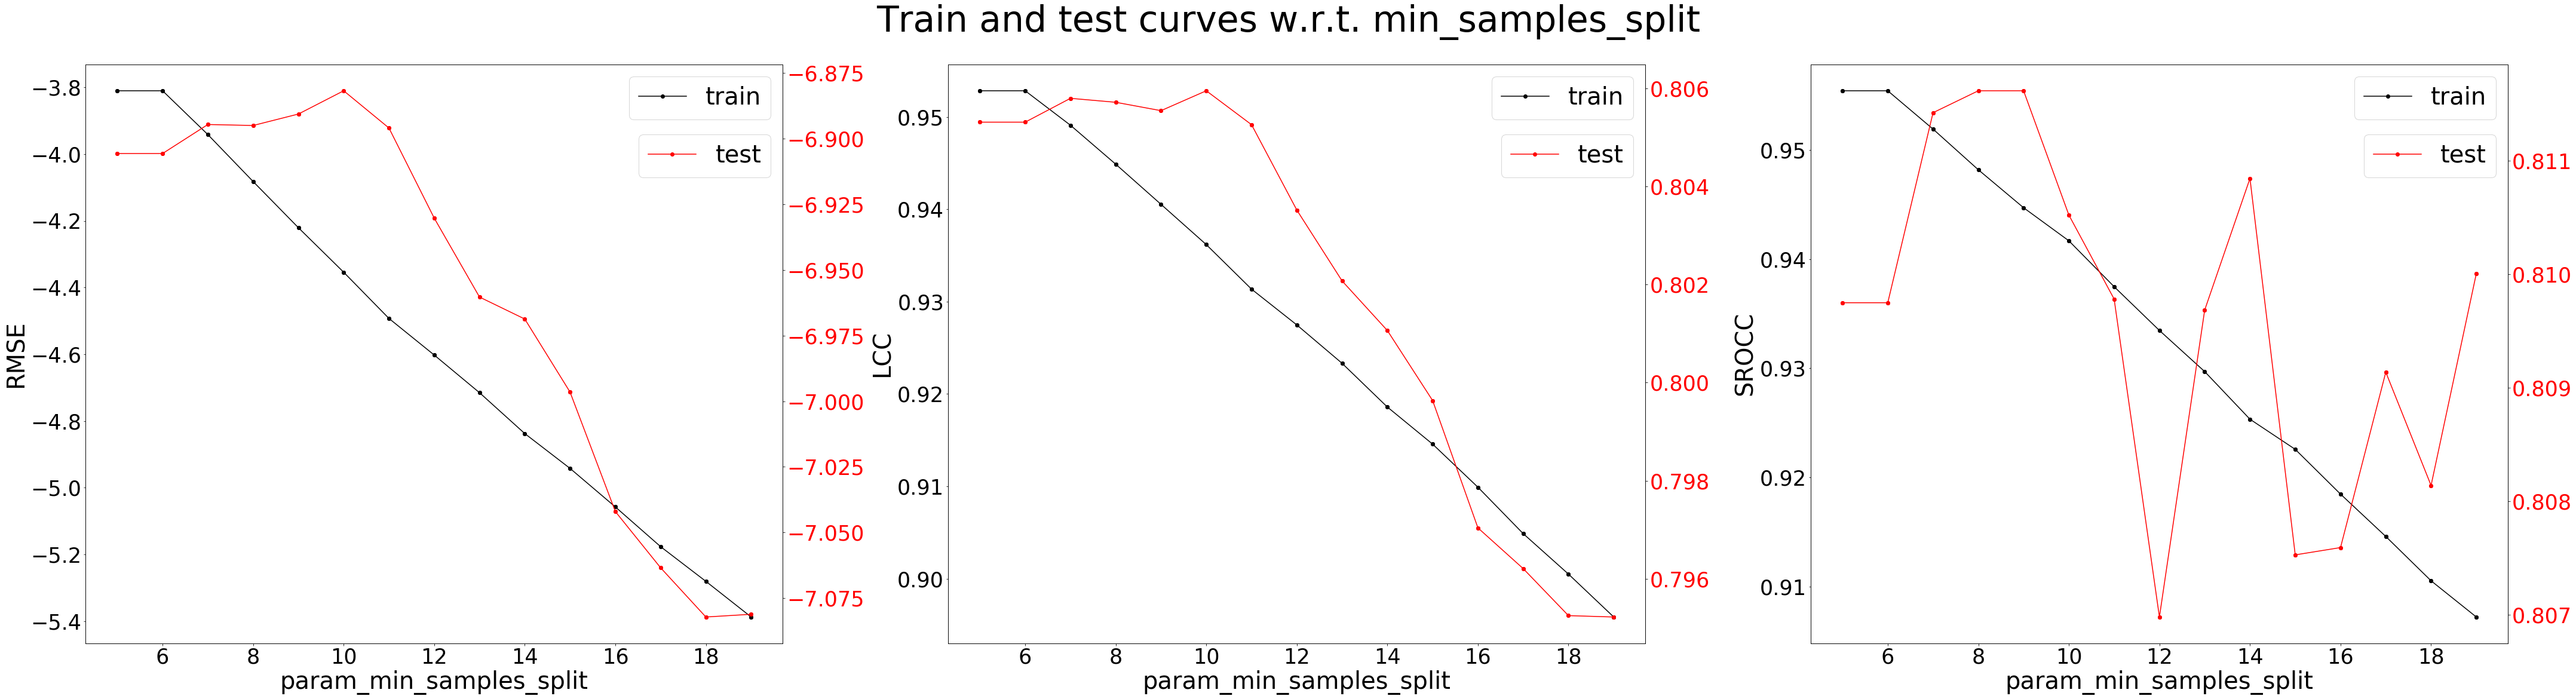

In [26]:
fig, ax = plt.subplots(1,3,figsize = [60,15])
for i, name in enumerate(scorer.keys()):
    ax[i].set_ylabel(name.upper(), fontsize = 40)
    ax[i].set_xlabel(param_name, fontsize = 40)
    ax[i].tick_params(labelsize=35)
    ax[i].tick_params(axis = 'y', labelcolor = 'k')
    ax[i].plot(param_value, parameters_grid_search_2nd.cv_results_['mean_train_' + name],'ko-',label = 'train')
    ax[i].legend(fontsize = 40, loc= 'best')
    ax2 = ax[i].twinx() 
    ax2.tick_params(labelsize=35)
    ax2.tick_params(axis = 'y', labelcolor = 'r')
    ax2.plot(param_value, parameters_grid_search_2nd.cv_results_['mean_test_' + name],'ro-',label = 'test')
    ax2.legend(loc='best', bbox_to_anchor=(0.5, 0, 0.5, 0.9),fontsize = 40)
fig.suptitle('Train and test curves w.r.t. min_samples_split',fontsize = 60,y=1.08)
plt.tight_layout()
plt.savefig("cv_select.pdf", bbox_inches='tight')

## Parameters grid search - third round

In [27]:
parameters_grid_3rd = {}

In [28]:
# initial the hyper-parameters grid used for third grid search
# based on the result from the best params of second grid search
# find the best n_estimators
parameters_grid_2nd['n_estimators'] = [100]
parameters_grid_3rd['n_estimators'] = [int(x) for x in range(100, 1000, 10)]
parameters_grid_3rd['criterion'] = ['mse']
parameters_grid_3rd['max_depth'] = [8]
parameters_grid_3rd['min_samples_split'] = [10]
parameters_grid_3rd['min_samples_leaf'] = [3]
parameters_grid_3rd['max_features'] = ['auto']
parameters_grid_3rd['bootstrap'] = [True]
parameters_grid_3rd['verbose'] = [0]
parameters_grid_3rd['oob_score'] = [True]

In [29]:
parameters_grid_search_3rd = GridSearchCV(estimator = Reg_video, param_grid = parameters_grid_3rd, 
                          cv = CV_Generator(features, labels, group_label), n_jobs = -1, verbose = 1, return_train_score=True, 
                                      error_score = np.nan, scoring = scorer, refit = 'rmse', iid=False)

In [30]:
parameters_grid_search_3rd.fit(features, labels)

Fitting 8 folds for each of 90 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.5min finished


GridSearchCV(cv=<generator object CV_Generator at 0x1a18b3b938>,
       error_score=nan,
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 6...ples_leaf': [3], 'max_features': ['auto'], 'bootstrap': [True], 'verbose': [0], 'oob_score': [True]},
       pre_dispatch='2*n_jobs', refit='rmse', retu

In [31]:
parameters_grid_search_3rd.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 130,
 'oob_score': True,
 'verbose': 0}

### Training curve

In [32]:
param_name = 'param_n_estimators'
param_value = parameters_grid_search_3rd.cv_results_[param_name]

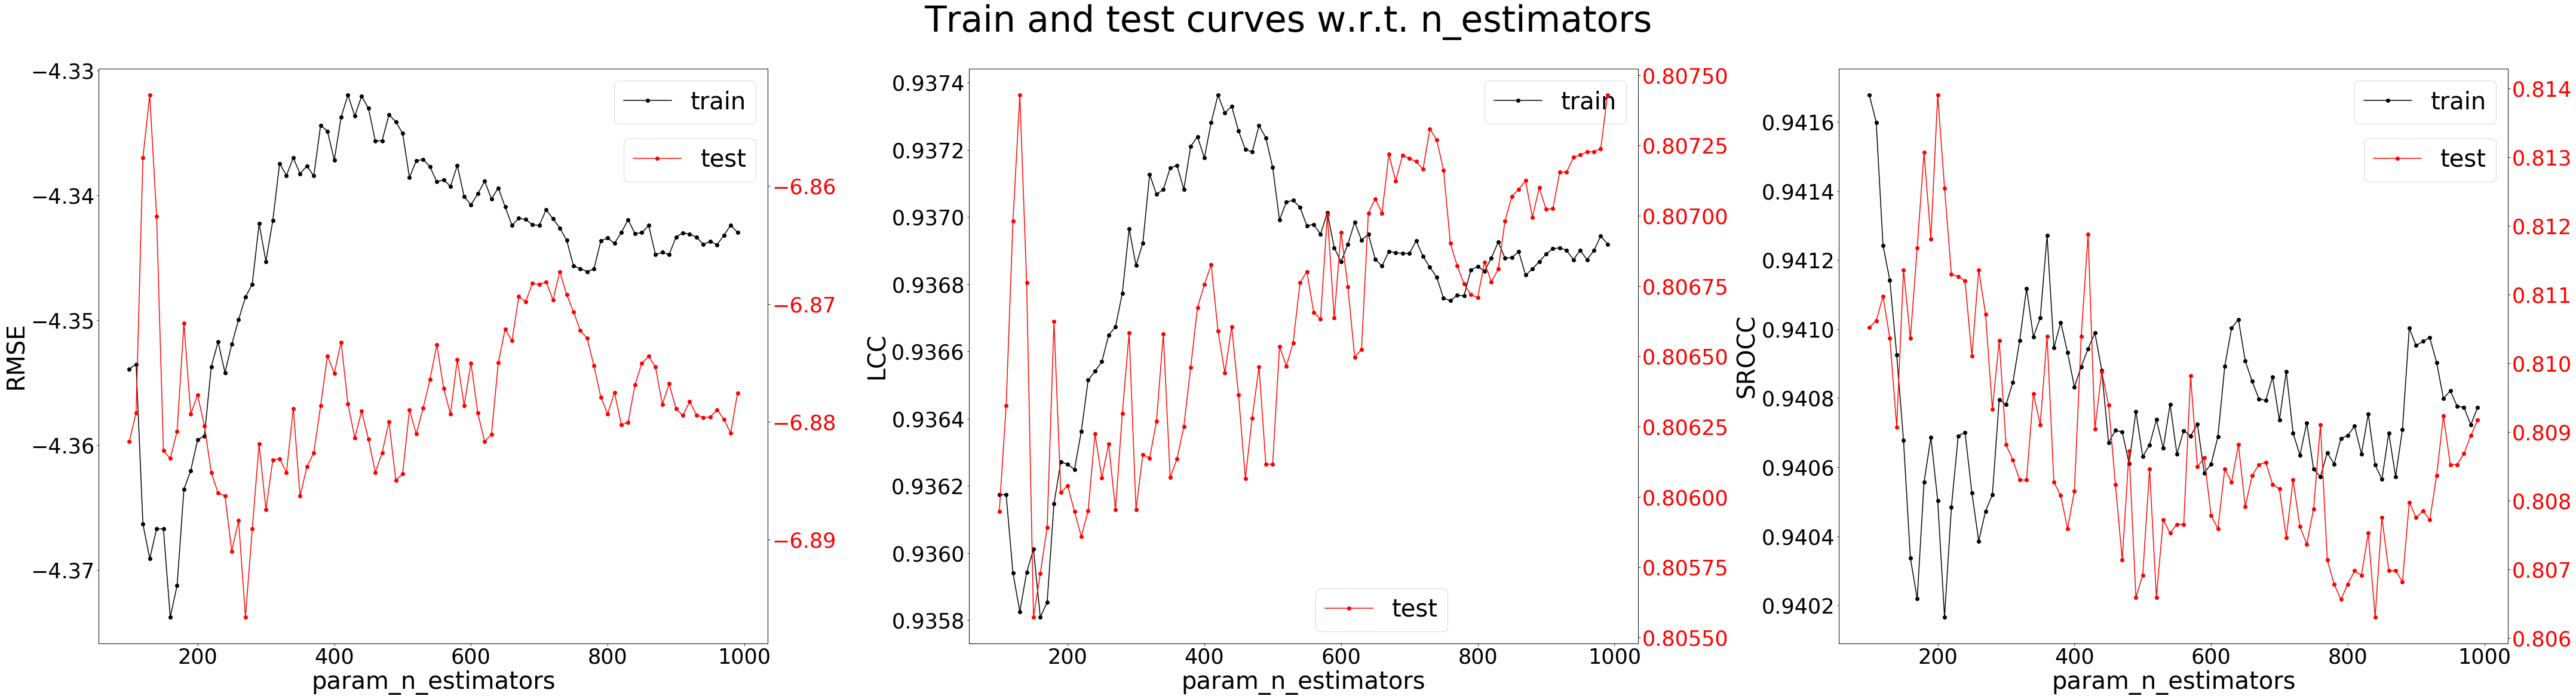

In [33]:
fig, ax = plt.subplots(1,3,figsize = [60,15])
for i, name in enumerate(scorer.keys()):
    ax[i].set_ylabel(name.upper(), fontsize = 40)
    ax[i].set_xlabel(param_name, fontsize = 40)
    ax[i].tick_params(labelsize=35)
    ax[i].tick_params(axis = 'y', labelcolor = 'k')
    ax[i].plot(param_value, parameters_grid_search_3rd.cv_results_['mean_train_' + name],'ko-',label = 'train')
    ax[i].legend(fontsize = 40, loc= 'best')
    ax2 = ax[i].twinx() 
    ax2.tick_params(labelsize=35)
    ax2.tick_params(axis = 'y', labelcolor = 'r')
    ax2.plot(param_value, parameters_grid_search_3rd.cv_results_['mean_test_' + name],'ro-',label = 'test')
    ax2.legend(loc='best', bbox_to_anchor=(0.5, 0, 0.5, 0.9),fontsize = 40)
fig.suptitle('Train and test curves w.r.t. n_estimators',fontsize = 60,y=1.08)
plt.tight_layout()

## Discover best training set

Randomly pick 80% of dataset for training, using measurement to find the best subset to build the model. Finally, random state = 8, the fifth training set provides best training.

In [34]:
idx = 0
for train_idx, test_idx in CV_Generator(features, labels, group_label, 16, test_ratio=0.2):
    train_features = features.iloc[train_idx]
    train_labels = labels.iloc[train_idx]
    test_features = features.iloc[test_idx]
    test_labels = labels.iloc[test_idx]
    best_model = parameters_grid_search_3rd.best_estimator_.fit(train_features, train_labels)
    train_pred = best_model.predict(train_features)
    test_pred = best_model.predict(test_features)
    if idx == 5:
        final_model = best_model
        best_train_idx = train_idx
        best_test_idx = test_idx
        print('Model saved')
    print('       train set            test set')
    print('RMSE', rmse(train_labels, train_pred), rmse(test_labels, test_pred))
    print('LCC', lcc(train_labels, train_pred), lcc(test_labels, test_pred))
    print('SROCC', srocc(train_labels, train_pred), srocc(test_labels, test_pred))
    print('Accuracy', accuracy(train_labels, train_pred), accuracy(test_labels, test_pred))
    print('\n')
    idx += 1

       train set            test set
RMSE 4.4237887275470404 6.531665545664803
LCC 0.9352243776274343 0.8445337057774442
SROCC 0.9443169656235283 0.8272844272844273
Accuracy 0.9327280952546221 0.8998566880243328


       train set            test set
RMSE 4.334452365839572 7.470458935747816
LCC 0.9256608128836753 0.8704291027338807
SROCC 0.9330322359690055 0.8576576576576578
Accuracy 0.9348648825626429 0.8785489299379513


       train set            test set
RMSE 4.469206511820765 7.7338458779421035
LCC 0.9362407332918496 0.661410642002654
SROCC 0.9438246500278263 0.7070785070785072
Accuracy 0.9343891661611267 0.88473710773594


       train set            test set
RMSE 4.062615111573338 7.7401703332848255
LCC 0.9460692740275327 0.7387484653583167
SROCC 0.9472494541718395 0.744916344916345
Accuracy 0.9386769655053496 0.8802881496353265


       train set            test set
RMSE 4.233228506463555 8.203328262711143
LCC 0.9407890571652876 0.7160633524777508
SROCC 0.9438674600796266 0.70

## Best model and performance

In [35]:
pprint(final_model.get_params())# the params for best model

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 130,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


In [36]:
train_features = features.iloc[best_train_idx]
train_labels = labels.iloc[best_train_idx]
test_features = features.iloc[best_test_idx]
test_labels = labels.iloc[best_test_idx]
train_pred = final_model.predict(train_features)
test_pred = final_model.predict(test_features)
print('  The accuracy of result of best model')
print('       train set            test set')
print('RMSE', rmse(train_labels, train_pred), rmse(test_labels, test_pred))
print('LCC', lcc(train_labels, train_pred), lcc(test_labels, test_pred))
print('SROCC', srocc(train_labels, train_pred), srocc(test_labels, test_pred))
print('Accuracy', accuracy(train_labels, train_pred), accuracy(test_labels, test_pred))

  The accuracy of result of best model
       train set            test set
RMSE 5.443677611003739 2.949932111840389
LCC 0.8987714004533585 0.9617563376194712
SROCC 0.9006592747977226 0.9500643500643502
Accuracy 0.9169796990804358 0.9525696032690034


## Visualize feature improtance

Visualize the feature weight given by random forest for reference in the future

In [37]:
feature_importance = pd.DataFrame(final_model.feature_importances_, index=features.columns, columns=['Weight'])

In [38]:
feature_importance = feature_importance.sort_values(by = 'Weight', ascending=False)

In [39]:
feature_importance

Weight
msssim         0.418129
TA             0.179502
psnrhvsm       0.146766
Blockloss      0.041077
SA             0.031288
Noise          0.030978
Interlace      0.029766
Blur           0.028791
ssim           0.018585
Flickering     0.016222
Contrast       0.014713
Exposure(bri)  0.011378
psnrhvs        0.009224
Blockiness     0.009112
psnr           0.008666
vifp           0.005802

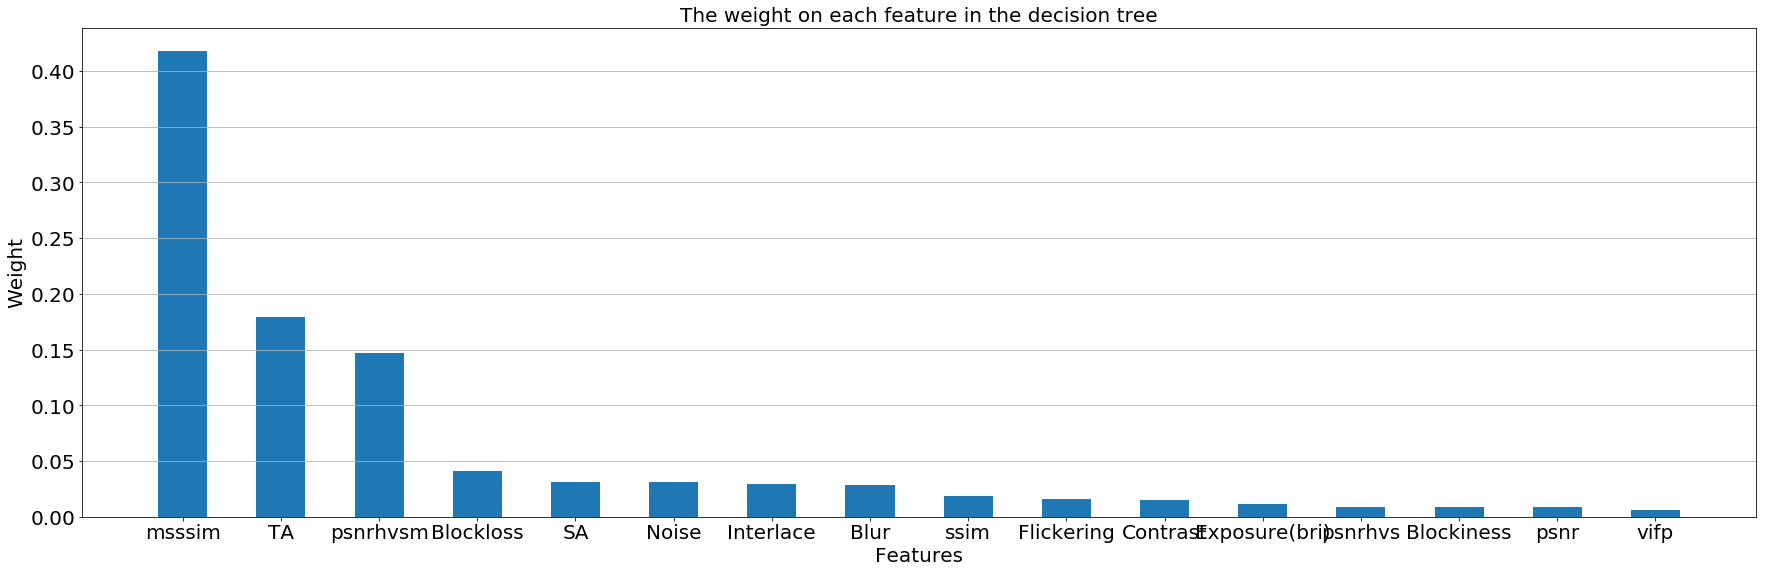

In [40]:
fig, ax = plt.subplots(figsize = (30, 9))
ax.set_title('The weight on each feature in the decision tree', fontsize = 20)
ax.tick_params(labelsize = 20)
ax.set_xlabel('Features', fontsize = 20)
ax.set_ylabel('Weight', fontsize = 20)
ax.grid(axis = 'y')
ax.bar(feature_importance.index, feature_importance['Weight'], width = 0.5)
plt.tight_layout
plt.savefig('feature_weight.pdf')

## Visualize the the comparison between actual and prediction

Visualize the predicted results, the effects of random forest is good

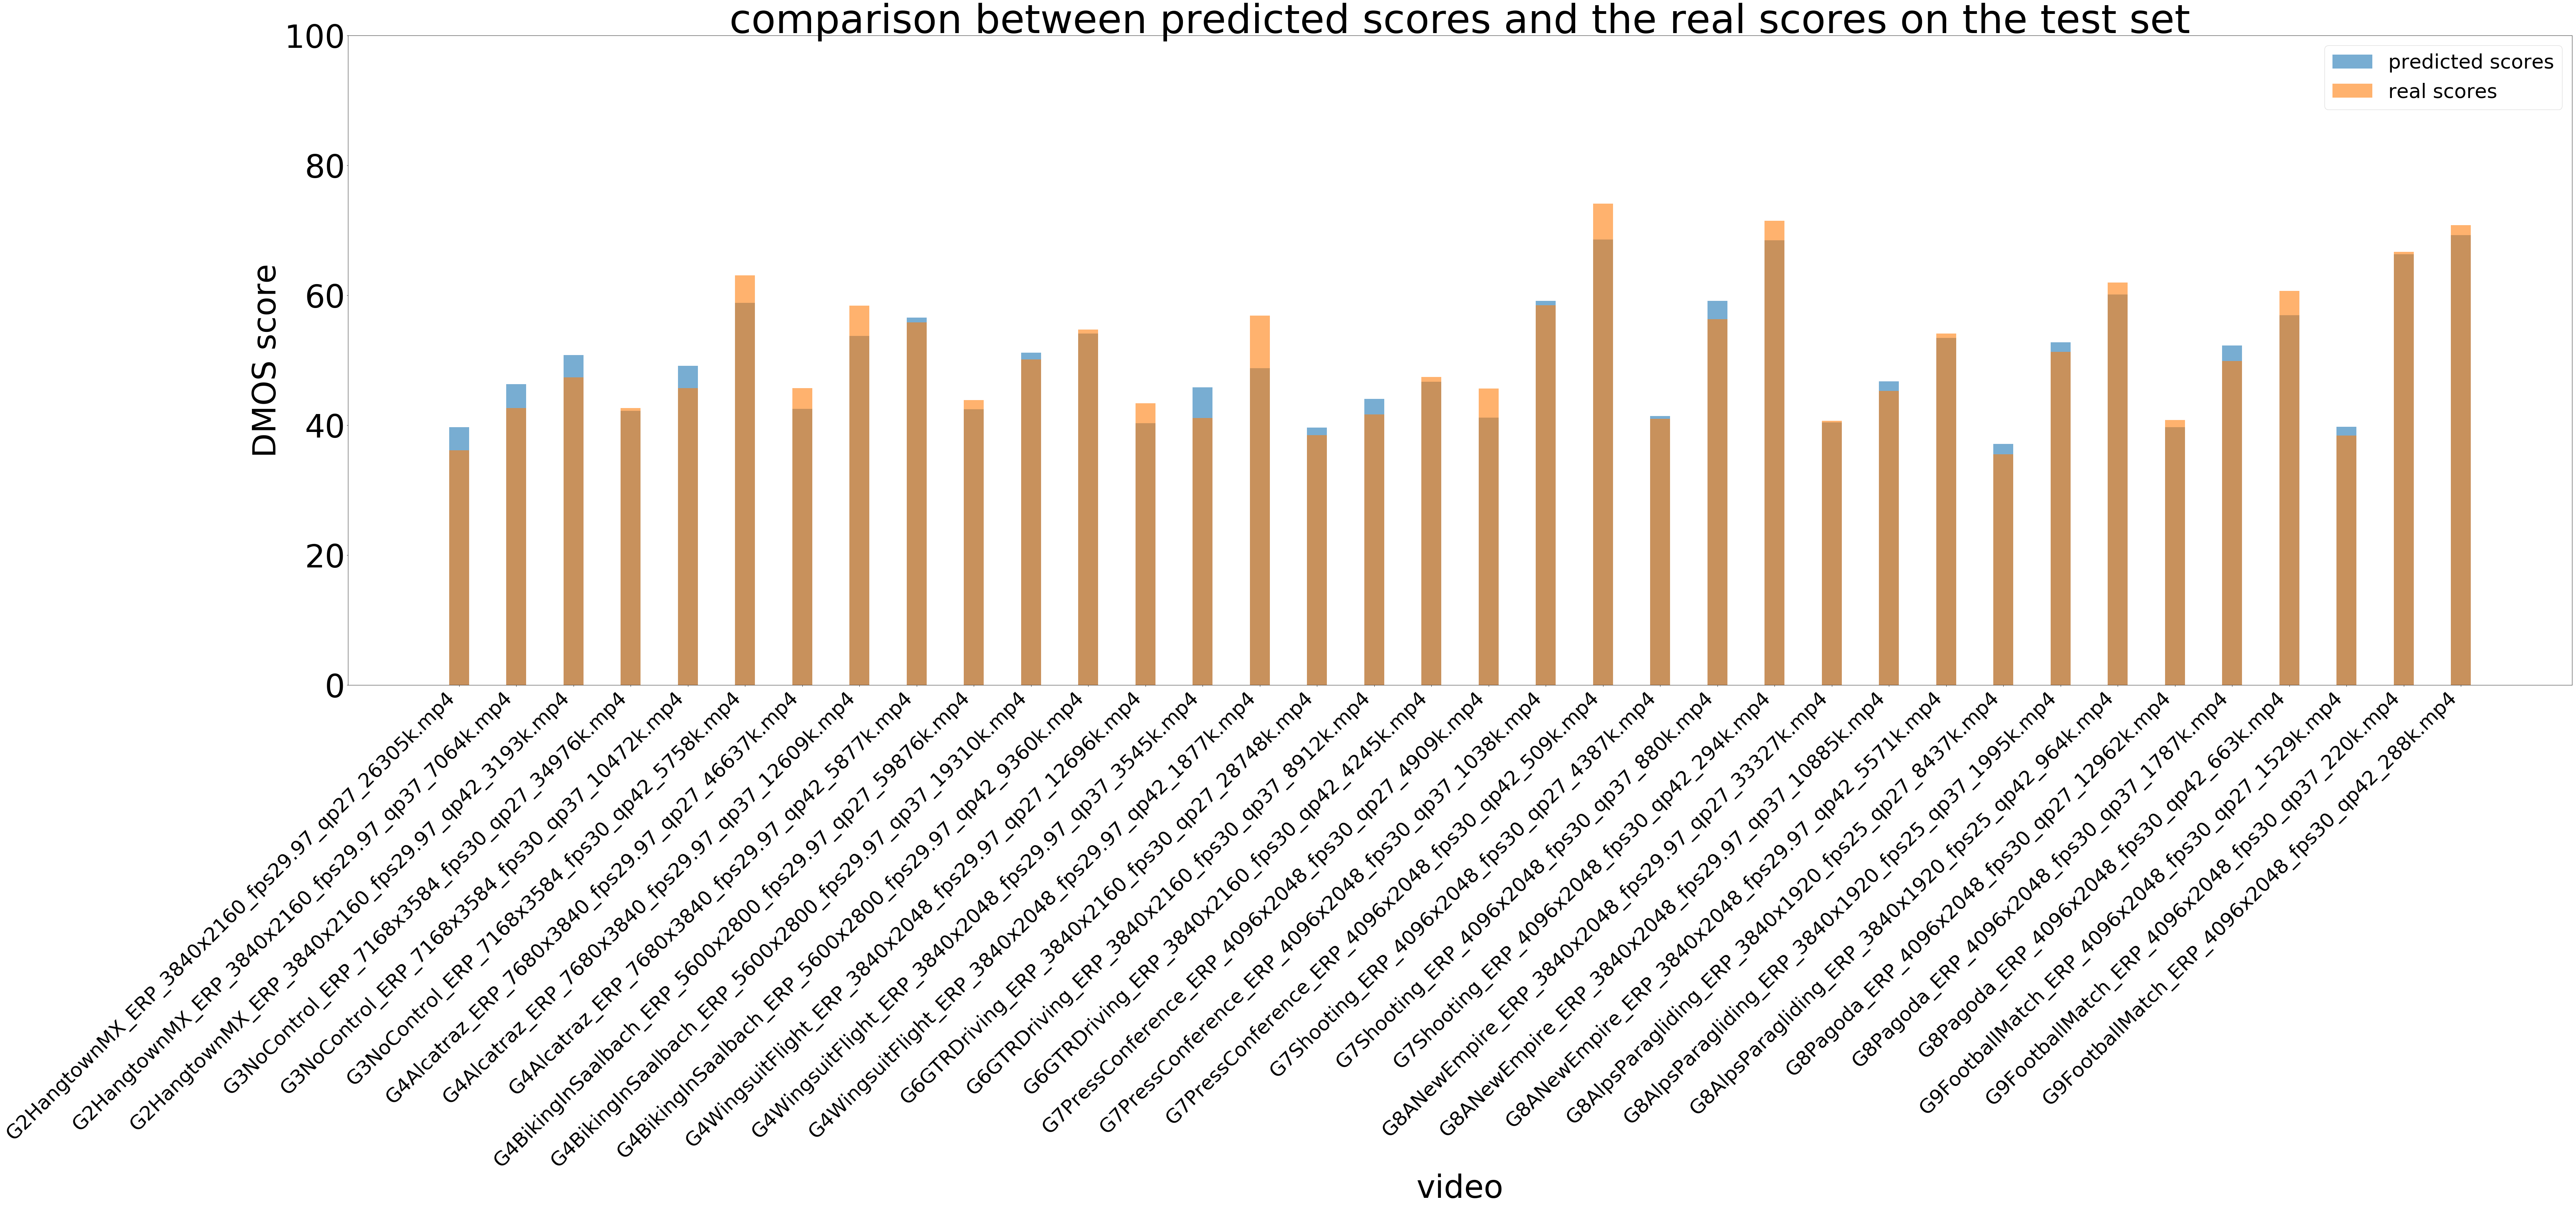

In [41]:
plt.subplots(figsize=(100,30))
plt.title('comparison between predicted scores and the real scores on the test set',fontsize=100) 
plt.xlabel('video',fontsize=80)
plt.ylabel('DMOS score',fontsize=80)
y_label=test_labels.index
plt.tick_params(labelsize=80)
# set interval for y label
plt.xticks(np.arange(test_labels.index.size),y_label,rotation = 45, fontsize = 50,ha='right')
plt.ylim([0,100])
plt.bar(np.arange(test_labels.index.size),test_pred,label="predicted scores",width=0.35,alpha=0.6,linewidth=20)
plt.bar(np.arange(test_labels.index.size),test_labels,label="real scores",width=0.35,alpha=0.6,linewidth=20)
plt.legend(fontsize=50)
plt.savefig("comparison_predict_real_rf.pdf", bbox_inches='tight')

## Visualize the best tree

In [42]:

visual_tree = final_model.estimators_[12]
export_graphviz(visual_tree, out_file = 'best_tree.dot', feature_names = feature_importance.index.values, precision = 2, filled = True, rounded = True, max_depth = None)

In [43]:
import pydot

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('best_tree.dot')
graph.write_pdf('best_tree.pdf')

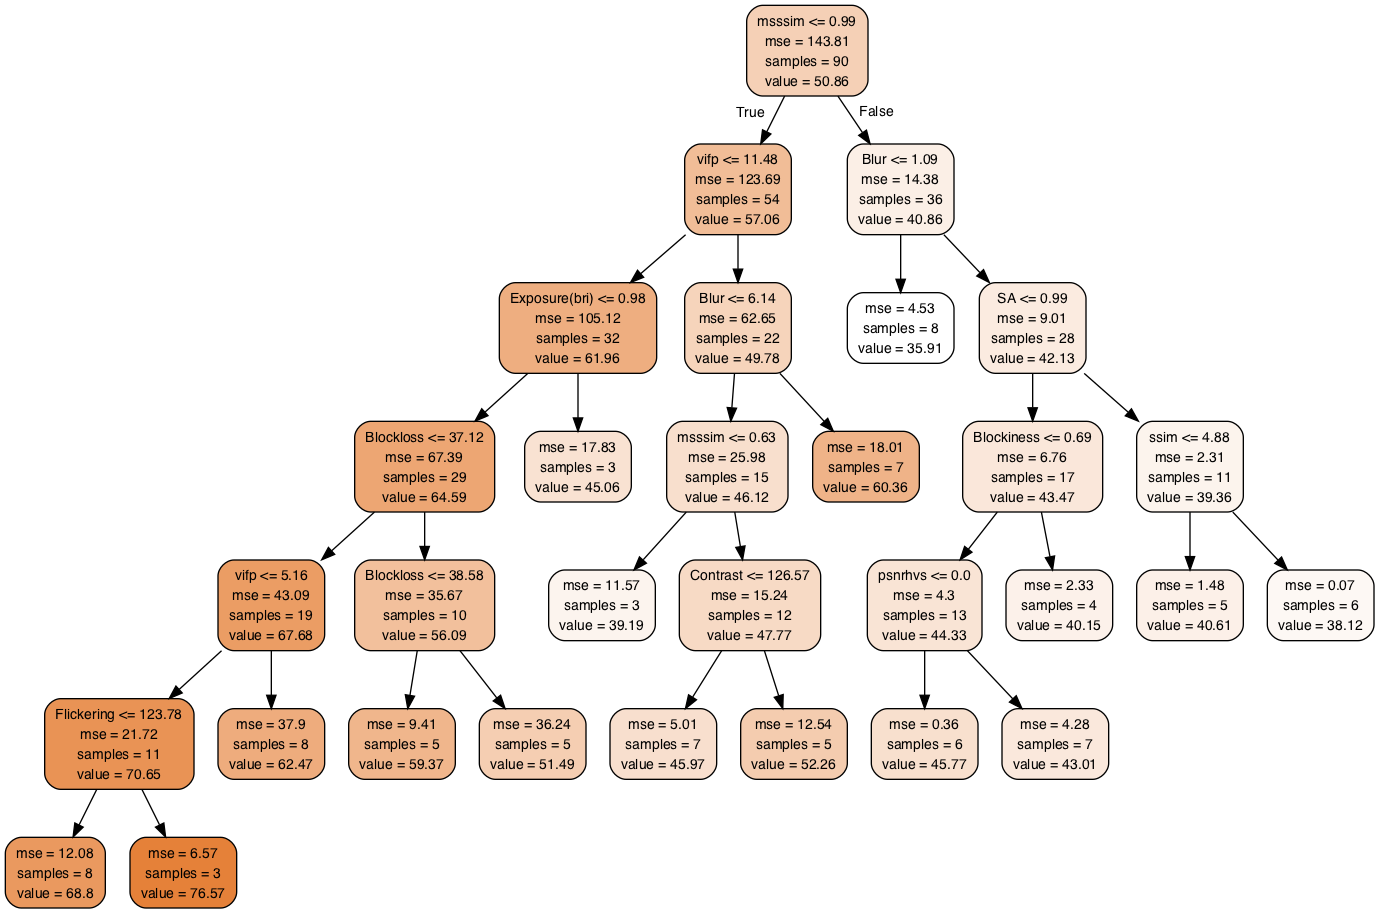

In [44]:
display.Image(graph.create_png()) # The structure of our best decision tree

# Support Vector Regression

## Perform Principal Component Analysis(PCA)

Visualize the feature in low dimension space

In [45]:
pca=PCA(n_components=1)
pca.fit(features)
feature_pca=pca.transform(features)

In [46]:
#sort the feature after PCA and the datascores
feature_pca_sort=np.sort(feature_pca,axis=0)
feature_pca_index=np.argsort(feature_pca,axis=0)
dataset_scores_sort=labels[feature_pca_index]

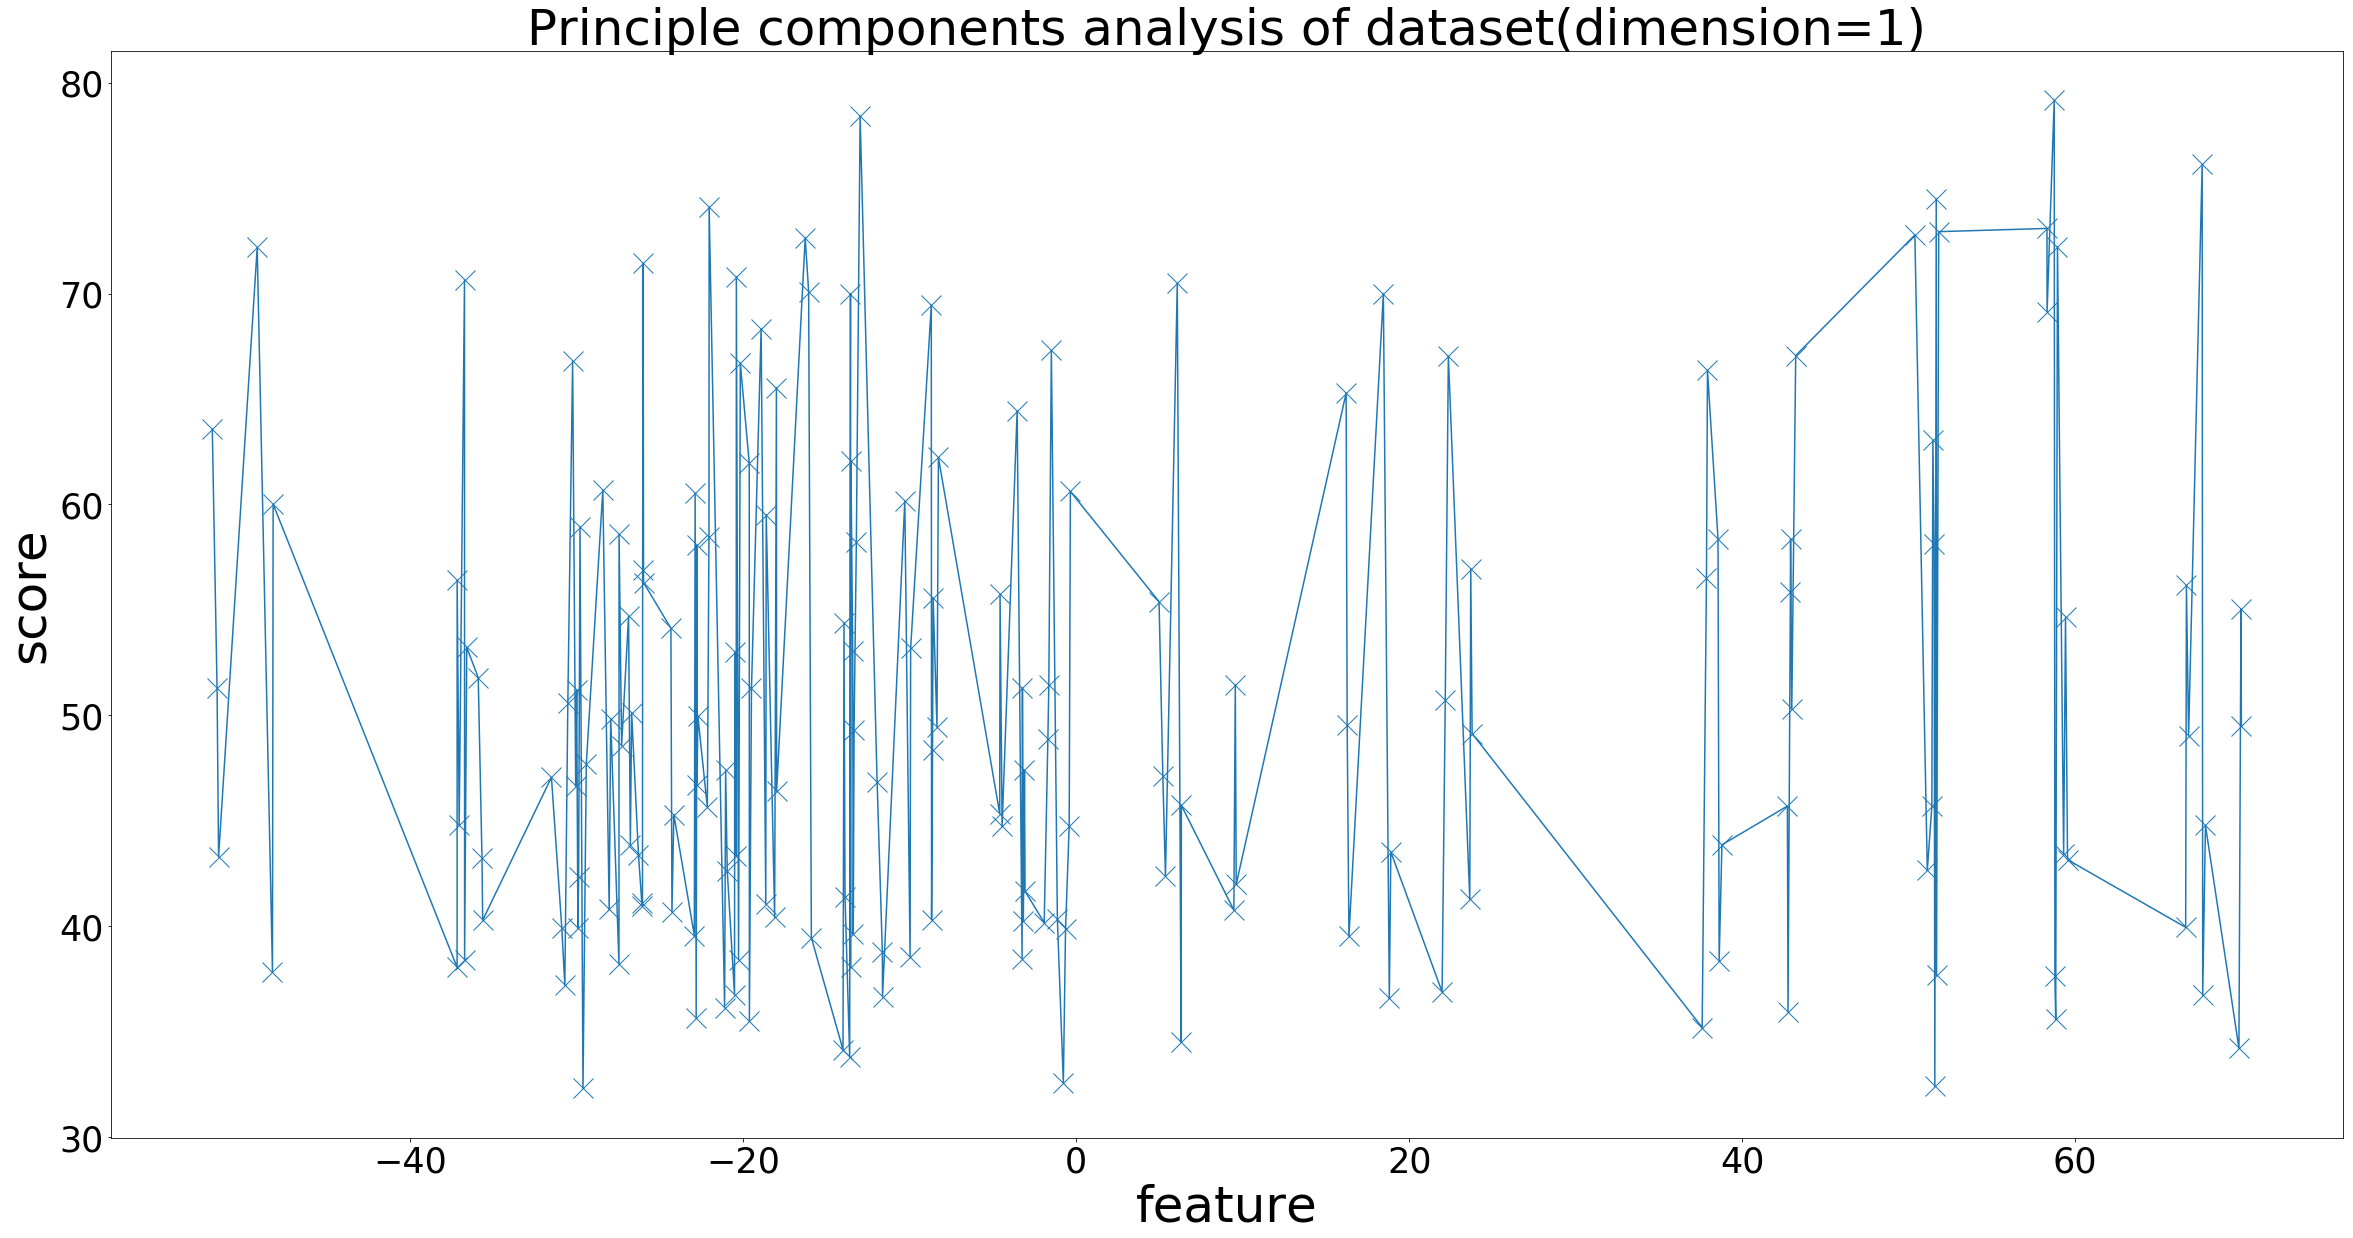

In [47]:
fig, ax1 = plt.subplots(figsize=(40,20))
ax1.plot(feature_pca_sort,dataset_scores_sort,'-x',markersize=20)
ax1.tick_params(labelsize=35)
ax1.set_xlabel('feature',fontsize=50)
ax1.set_ylabel('score',fontsize=50)
ax1.set_title('Principle components analysis of dataset(dimension=1)',fontsize=50)
plt.savefig('pca.pdf')

## Grid search 

In [48]:
#define svr model
model_svr = svm.SVR(max_iter=6000)

In [49]:
#grid search for the best parameters for SVR
ParameterGrid={}
ParameterGrid['C']=np.arange(1,50,1) 
ParameterGrid['gamma']= [0.01, 0, 'auto', 'scale']
ParameterGrid['verbose'] = [0, 1]
ParameterGrid['degree'] = [2, 3]
ParameterGrid['kernel'] = ['rbf', 'poly']
ParameterGrid['tol'] = [0.1, 0.01, 0.001]
#ParameterGrid['epsilon'] = np.arange(0.05,0.15,0.01)

In [50]:
grid_search_svr= GridSearchCV(estimator = model_svr, param_grid = ParameterGrid, 
                          cv = CV_Generator(features, labels, group_label), n_jobs = -1, verbose = 1, return_train_score=True, 
                                      error_score = np.nan,scoring = scorer, refit = 'rmse', iid=False)

In [51]:
grid_search_svr.fit(features, labels)

Fitting 8 folds for each of 4704 candidates, totalling 37632 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2436 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 4536 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 7236 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 14436 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 18936 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 24036 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 29736 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 36036 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 37632 out of 37632 | elapsed:  2.7min finished
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre

GridSearchCV(cv=<generator object CV_Generator at 0x111482e60>,
       error_score=nan,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=6000, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'gamma': [0.01, 0, 'auto', 'scale'], 'verbose': [0, 1], 'degree': [2, 3], 'kernel': ['rbf', 'poly'], 'tol': [0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score=True,
       scoring={'rmse': make_scorer(rmse, greater_is_better=False), 'lcc': make_scorer(lcc), 'srocc': make_scorer(srocc)},
       verbose=1)

In [52]:
idx = 0
for train_idx, test_idx in CV_Generator(features, labels, group_label, 40, test_ratio=0.2):
    train_features = features.iloc[train_idx]
    train_labels = labels.iloc[train_idx]
    test_features = features.iloc[test_idx]
    test_labels = labels.iloc[test_idx]
    best_model = grid_search_svr.best_estimator_.fit(train_features, train_labels)
    train_pred = best_model.predict(train_features)
    test_pred = best_model.predict(test_features)
    if idx ==22:
        final_model = best_model
        best_train_idx = train_idx
        best_test_idx = test_idx
        print('Model saved')
    print('RMSE:', rmse(train_labels, train_pred), rmse(test_labels, test_pred))
    print('LCC:', lcc(train_labels, train_pred), lcc(test_labels, test_pred))
    print('SROCC:', srocc(train_labels, train_pred), srocc(test_labels, test_pred))
    print('Accuracy:', accuracy(train_labels, train_pred), accuracy(test_labels, test_pred))
    print('\n')
    idx += 1

/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Use

RMSE: 6.788050254331957 6.452037231545985
LCC: 0.817485807417552 0.8480230898979729
SROCC: 0.8280919559912667 0.8854568854568854
Accuracy: 0.9016467702630058 0.8995114692196913


RMSE: 6.818530973238758 8.202418157418114
LCC: 0.7842268433704753 0.8709160279117377
SROCC: 0.8096793527120166 0.88005148005148
Accuracy: 0.903375273605694 0.8769838968998399


RMSE: 6.738410319998591 6.380514751934707
LCC: 0.8364941649311762 0.7731730889647014
SROCC: 0.8612825891519329 0.8018018018018018
Accuracy: 0.9038180198904332 0.8959357570443688


RMSE: 6.702711152066622 10.104275361627426
LCC: 0.8258204384787259 0.5784533429018652
SROCC: 0.8518258487092768 0.5845559845559846
Accuracy: 0.8982222830307647 0.8428776043315727


RMSE: 5.9928230182596005 10.803889906927115
LCC: 0.8669541961227514 0.59340159943699
SROCC: 0.891656320904148 0.5873873873873875
Accuracy: 0.9096068845984553 0.8259287933712326


RMSE: 6.763657576003043 7.730375795766549
LCC: 0.829825827279855 0.7825975952022877
SROCC: 0.84532728284

/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Use

SROCC: 0.8318035874823407 0.8509652509652511
Accuracy: 0.8947324260595022 0.9014505081147837


RMSE: 6.717810611338993 6.049606458070889
LCC: 0.824322053746432 0.8745235106394853
SROCC: 0.8542874266877861 0.8414414414414414
Accuracy: 0.89863368655512 0.8953908854079797


RMSE: 7.328492162804736 7.530786550291877
LCC: 0.8077599590851544 0.6870785052527986
SROCC: 0.8071963697076072 0.708880308880309
Accuracy: 0.8841633931068623 0.877957269203614


RMSE: 6.797402064973495 7.092658152484825
LCC: 0.8128620265445785 0.8158562748400499
SROCC: 0.841333105013057 0.8198198198198199
Accuracy: 0.90291376622281 0.8765579940215928


RMSE: 6.803924034475151 6.966197385956503
LCC: 0.8070272887745852 0.885432498300527
SROCC: 0.8235112804486494 0.8952380952380953
Accuracy: 0.8982128424446735 0.904525249266605


RMSE: 6.988392108166894 7.4686695602203805
LCC: 0.7911937787191679 0.8300143224361414
SROCC: 0.8148251209383963 0.846846846846847
Accuracy: 0.8993053669155457 0.8834834266538439


RMSE: 6.6756091

/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Use

RMSE: 6.612068564825519 11.016132257695318
LCC: 0.8195383243866325 0.597054159464662
SROCC: 0.8193801104499334 0.6836550836550838
Accuracy: 0.9038095164241844 0.8406074159395143


RMSE: 6.151759222959401 8.519981079291293
LCC: 0.8374078854604203 0.783347039757465
SROCC: 0.8428956719037629 0.7930501930501931
Accuracy: 0.9081347930745136 0.856430009158542


RMSE: 6.684065466416098 9.743552133741572
LCC: 0.8303308167119835 0.6209812864016618
SROCC: 0.8556744723661115 0.6594594594594595
Accuracy: 0.8984951392780707 0.8539359676744691


RMSE: 6.378597844140498 7.557525396895101
LCC: 0.8399851477669785 0.777934429257907
SROCC: 0.859000813390984 0.7786357786357788
Accuracy: 0.9060366493886086 0.8824021547272044


RMSE: 6.4897019105549125 12.556841508745574
LCC: 0.841225896804984 0.6419929366648766
SROCC: 0.8531272742840017 0.5371943371943372
Accuracy: 0.9024966066856023 0.7982780111843673


RMSE: 6.48912980076341 10.372651513184742
LCC: 0.8436986977643983 0.7038664983838729
SROCC: 0.864296416

/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Visualize results

In [53]:
train_features = features.iloc[best_train_idx]
train_labels = labels.iloc[best_train_idx]
test_features = features.iloc[best_test_idx]
test_labels = labels.iloc[best_test_idx]
train_pred = final_model.predict(train_features)
test_pred = final_model.predict(test_features)
print('  The accuracy of result of best model')
print('       train set            test set')
print('RMSE', rmse(train_labels, train_pred), rmse(test_labels, test_pred))
print('LCC', lcc(train_labels, train_pred), lcc(test_labels, test_pred))
print('SROCC', srocc(train_labels, train_pred), srocc(test_labels, test_pred))
print('Accuracy', accuracy(train_labels, train_pred), accuracy(test_labels, test_pred))

  The accuracy of result of best model
       train set            test set
RMSE 8.951440770116832 5.543049209137501
LCC 0.7128417412875961 0.8798182328092617
SROCC 0.7877477631747933 0.8998712998712999
Accuracy 0.8785704564858217 0.9256473390635246


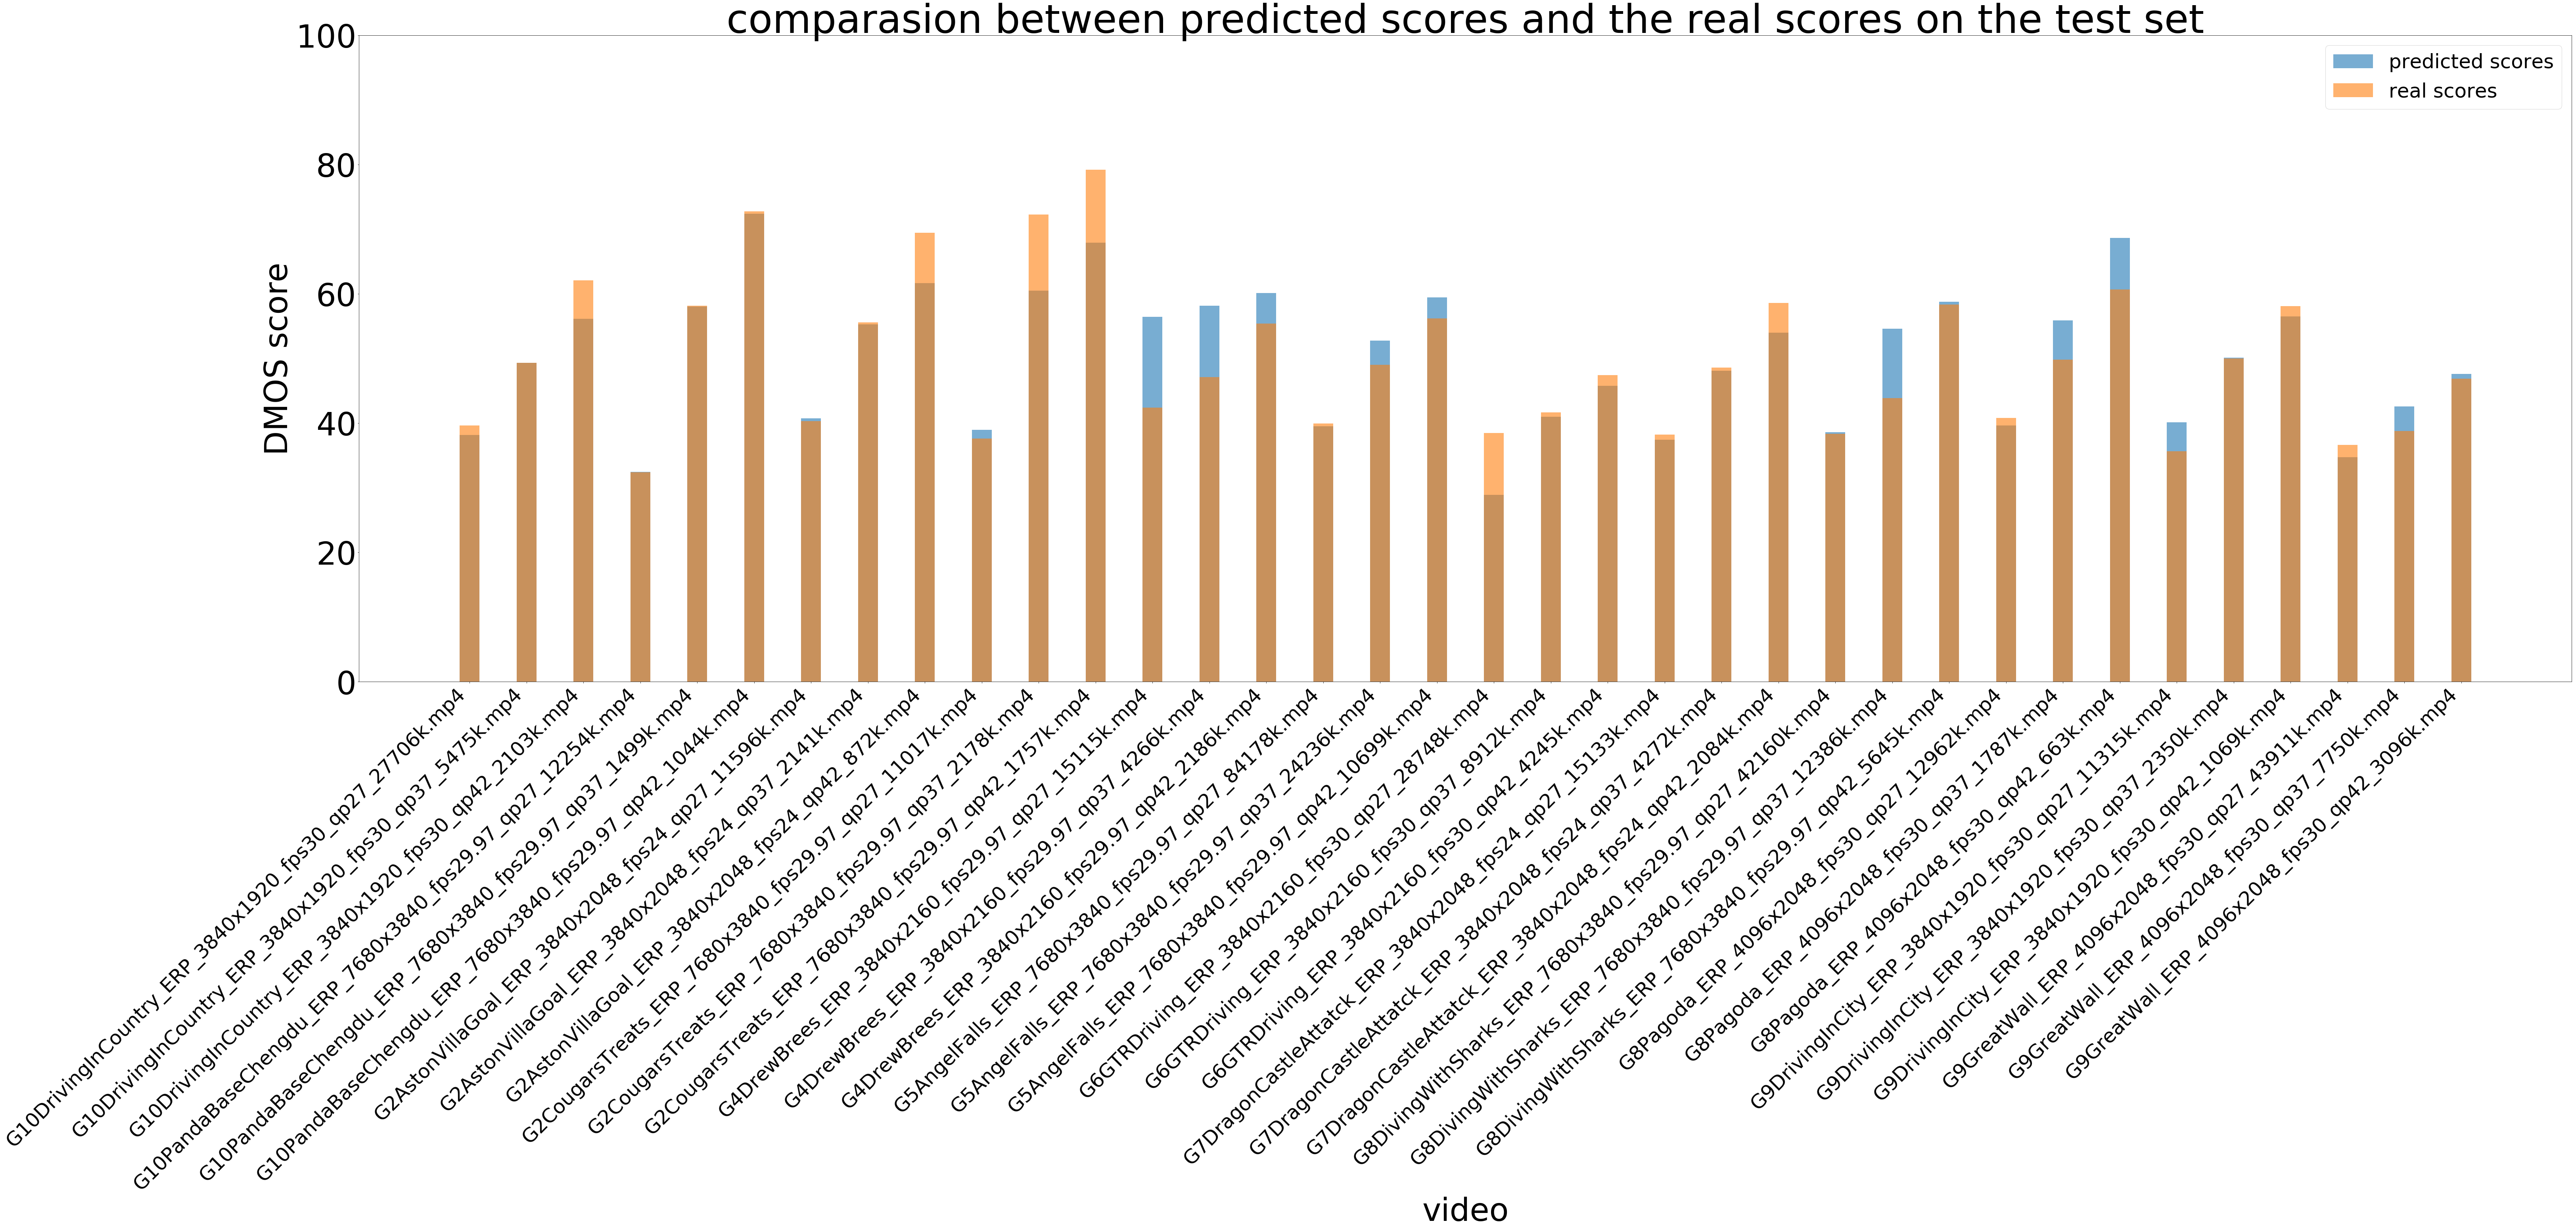

In [55]:
plt.subplots(figsize=(100,30))
plt.title('comparison between predicted scores and the real scores on the test set',fontsize=100) 
plt.xlabel('video',fontsize=80)
plt.ylabel('DMOS score',fontsize=80)
y_label=test_labels.index
plt.tick_params(labelsize=80)
# set interval for y label
plt.xticks(np.arange(test_labels.index.size),y_label,rotation = 45, fontsize = 50,ha='right')
plt.ylim([0,100])
plt.bar(np.arange(test_labels.index.size),test_pred,label="predicted scores",width=0.35,alpha=0.6,linewidth=20)
plt.bar(np.arange(test_labels.index.size),test_labels,label="real scores",width=0.35,alpha=0.6,linewidth=20)
plt.legend(fontsize=50)
plt.savefig("comparison_predict_real.pdf", bbox_inches='tight')